Evaluates a PGD adversarial trained model for **epsilon 0.5**, where both only out-domain samples
were transformed to adversarial samples using **dist uncertainty loss** to obtain adversarial gradients during each epoch. So training runs on normal images for 1 epoch and on adversarial images for another time.

In [1]:
import sys
import os
sys.path.append('/nfs/homedirs/giri/masterthesis')
os.chdir('/nfs/homedirs/giri/masterthesis')

In [2]:
import torch
from sklearn.metrics import precision_recall_curve,auc,roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap
from pylab import rcParams
from PIL import Image
from IPython.display import display
from robust_priornet.eval.model_prediction_eval import ClassifierPredictionEvaluator
from robust_priornet.eval.uncertainty import UncertaintyMeasuresEnum
from robust_priornet.utils.visualizer import plot_adv_samples,plot_all_roc_curves, plot_all_pr_curves, plot_adv_samples_ood, plot_many_epsilon_curves, plot_epsilon_curve
from robust_priornet.attack_priornet import plot_ood_attack_success,plot_mis_adv_success
from robust_priornet.training.adversarial_trainer import get_optimal_threshold

In [3]:
model_dir="runtime-model-vgg6-50epochs-adgen-robust-duncertainty-out"
batch_size=64
n_in=28
num_channels=1
data_dir="./runtime-data"
in_dataset="MNIST"
ood_dataset="OMNIGLOT"

### Utils

In [4]:
def display_pr_roc_curves(model_dir, eval_dir, uncertainty_measure: UncertaintyMeasuresEnum):
    #figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
    img = Image.open(os.path.join(model_dir, eval_dir, f'{uncertainty_measure._value_}_PR_Curve.png'))
    display(img)
    img = Image.open(os.path.join(model_dir, eval_dir, f'{uncertainty_measure._value_}_ROC_Curve.png'))
    display(img)

In [5]:
def create_vis_plots(org_eval_dir, attack_dir, epsilon, plots_dir='vis', misclassified_indices=[], limit=None):
    # all images are saved in 'vis' directory under attack folder
    misclassified_samples = plot_adv_samples(org_eval_dir, attack_dir, epsilon, plots_dir, misclassified_indices, limit=limit)

    last_batch = misclassified_samples - (misclassified_samples%10) if limit is None else (limit-10)
    display(Image.open(f"{attack_dir}/e{epsilon}-attack/{plots_dir}/result_vis_{last_batch}.png")) # prints the last but one batch

## Model Evaluation

### Misclassify detect task (only In domain dataset) evaluation (CPU)
#### For GPU eval, use seml script eval_seml.py

In [6]:
out_dir=model_dir+"/eval"

In [7]:
cmd = f"python -m robust_priornet.eval_priornet --gpu -1 --model_dir {model_dir} --result_dir {out_dir} --task misclassification_detect --batch_size {batch_size} {data_dir} {in_dataset} OMNIGLOT"
print(cmd)

python -m robust_priornet.eval_priornet --gpu -1 --model_dir runtime-model-vgg6-50epochs-adgen-robust-duncertainty-out --result_dir runtime-model-vgg6-50epochs-adgen-robust-duncertainty-out/eval --task misclassification_detect --batch_size 64 ./runtime-data MNIST OMNIGLOT


In [8]:
os.system(cmd)

0

#### Evaluation results - CONFIDENCE

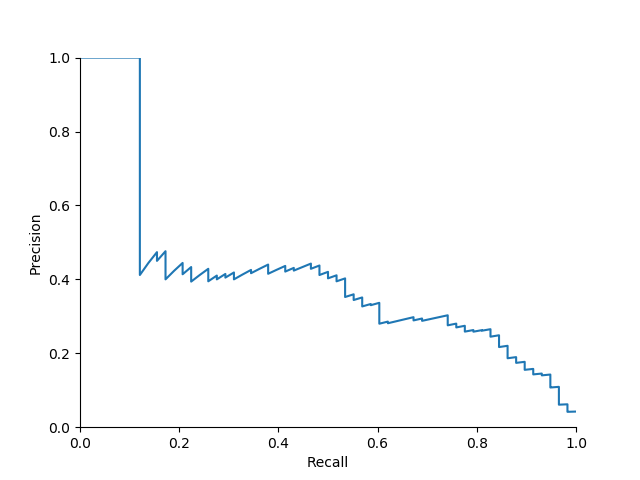

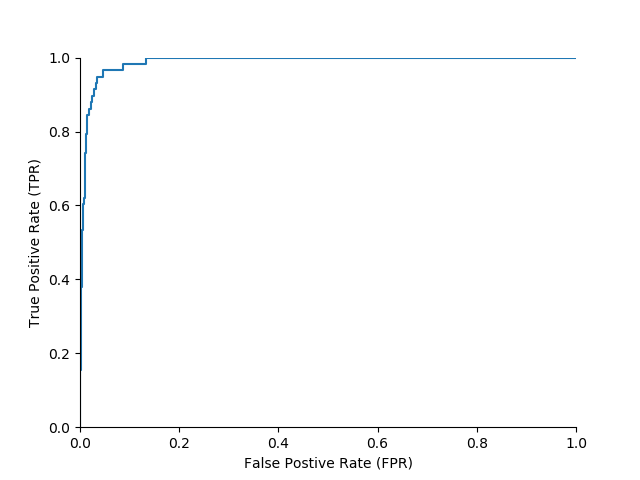

In [9]:
display_pr_roc_curves(model_dir, 'eval', UncertaintyMeasuresEnum.CONFIDENCE)

#### Evaluation results - overall

In [10]:
# Model's evaluation results for misclassification task
with open(f'{model_dir}/eval/results.txt', 'r') as f:
    print(f.read())

Classification Error: 0.6 
NLL: 3.9839999675750732 
AUPR using confidence: 40.8
AUROC using confidence: 98.9
AUPR using total_uncertainty: 32.9
AUROC using total_uncertainty: 98.7
AUPR using expected_data_uncertainty: 30.4
AUROC using expected_data_uncertainty: 98.7
AUPR using distributional_uncertainty: 26.4
AUROC using distributional_uncertainty: 98.3
AUPR using differential_entropy: 27.3
AUROC using differential_entropy: 98.4



### OOD Detect task (Both In-domain and OOD dataset) evaluation (CPU)
#### For GPU eval, use seml script eval_seml.py

In [14]:
ood_dataset="CIFAR10"
out_dir=model_dir+"/ood-eval-cifar10"

In [15]:
cmd = f"python -m robust_priornet.eval_priornet --gpu -1 --batch_size {batch_size} --task ood_detect --model_dir {model_dir} --result_dir {out_dir} {data_dir} {in_dataset} {ood_dataset}"
print(cmd)

python -m robust_priornet.eval_priornet --gpu -1 --batch_size 64 --task ood_detect --model_dir runtime-model-vgg6-50epochs-adgen-robust-duncertainty-out --result_dir runtime-model-vgg6-50epochs-adgen-robust-duncertainty-out/ood-eval-cifar10 ./runtime-data MNIST CIFAR10


In [16]:
os.system(cmd)

0

#### Evaluation results - CONFIDENCE

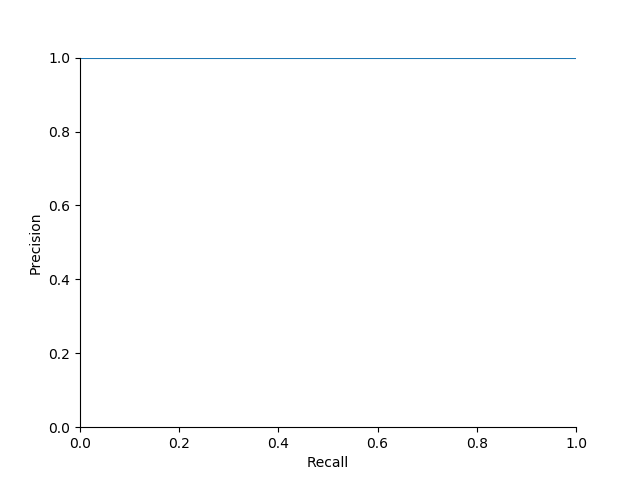

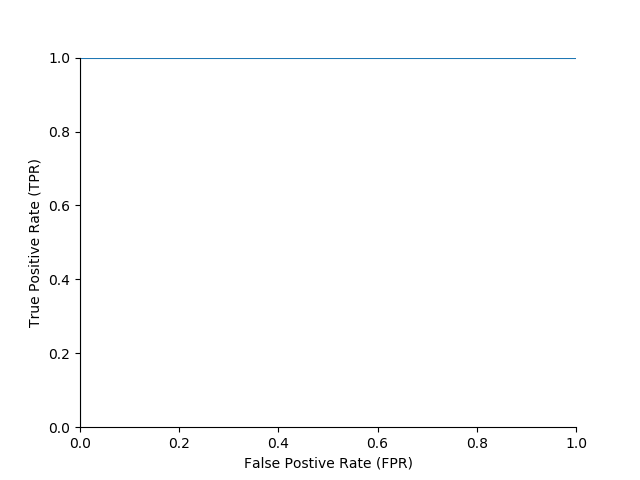

In [17]:
display_pr_roc_curves(model_dir, 'ood-eval', UncertaintyMeasuresEnum.CONFIDENCE)

#### Evaluation results - overall

In [18]:
# VGG6 Model's evaluation results for ood detect task - against OMNIGLOT (ood dataset used in training)
with open(f'{model_dir}/ood-eval/results.txt', 'r') as f:
    print(f.read())

Classification Error: 0.6 
NLL: 3.9839999675750732 
AUPR using confidence: 100.0
AUROC using confidence: 100.0
AUPR using total_uncertainty: 100.0
AUROC using total_uncertainty: 100.0
AUPR using expected_data_uncertainty: 100.0
AUROC using expected_data_uncertainty: 100.0
AUPR using distributional_uncertainty: 64.2
AUROC using distributional_uncertainty: 99.9
AUPR using differential_entropy: 100.0
AUROC using differential_entropy: 100.0



In [20]:
# VGG6 Model's evaluation results for ood detect task - against CIFAR10 (ood dataset not seen during training)
with open(f'{model_dir}/ood-eval-cifar10/results.txt', 'r') as f:
    print(f.read())

Classification Error: 0.6 
NLL: 3.9839999675750732 
AUPR using confidence: 100.0
AUROC using confidence: 100.0
AUPR using total_uncertainty: 100.0
AUROC using total_uncertainty: 100.0
AUPR using expected_data_uncertainty: 100.0
AUROC using expected_data_uncertainty: 100.0
AUPR using distributional_uncertainty: 99.6
AUROC using distributional_uncertainty: 99.9
AUPR using differential_entropy: 100.0
AUROC using differential_entropy: 100.0



## Estimating thresholds of Uncertainty Measures for ood-detect attacks

### MNIST + OMNIGLOT (valset)

In [4]:
ood_dataset = "OMNIGLOT"
out_dir=model_dir+"/ood-eval-val"
cmd = f"python -m robust_priornet.eval_priornet --gpu -1 --batch_size {batch_size} --task ood_detect --val_dataset --model_dir {model_dir} --result_dir {out_dir} {data_dir} {in_dataset} {ood_dataset}"
print(cmd)

python -m robust_priornet.eval_priornet --gpu -1 --batch_size 64 --task ood_detect --val_dataset --model_dir runtime-model-vgg6-50epochs-adgen-robust-duncertainty-out --result_dir runtime-model-vgg6-50epochs-adgen-robust-duncertainty-out/ood-eval-val ./runtime-data MNIST OMNIGLOT


In [22]:
os.system(cmd)

0

In [5]:
np.round(get_optimal_threshold(out_dir, UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY),4)

Max fn value:  1.0
Threshold: -12.853608131408691, TPR: 1.0, FPR: 0.0


-12.8536

In [6]:
np.round(get_optimal_threshold(out_dir, UncertaintyMeasuresEnum.DISTRIBUTIONAL_UNCERTAINTY),4)

Max fn value:  0.9985
Threshold: 0.37585020065307617, TPR: 1.0, FPR: 0.0015


0.3759

In [7]:
np.round(get_optimal_threshold(out_dir, UncertaintyMeasuresEnum.CONFIDENCE), 4)

Max fn value:  1.0
Threshold: -0.11543533951044083, TPR: 1.0, FPR: 0.0


-0.1154

### MNIST + CIFAR10 (valset)

In [27]:
ood_dataset = "CIFAR10"
out_dir=model_dir+"/ood-eval-val-cifar10"
cmd = f"python -m robust_priornet.eval_priornet --gpu -1 --batch_size {batch_size} --task ood_detect --val_dataset --model_dir {model_dir} --result_dir {out_dir} {data_dir} {in_dataset} {ood_dataset}"
print(cmd)

python -m robust_priornet.eval_priornet --gpu -1 --batch_size 64 --task ood_detect --val_dataset --model_dir runtime-model-vgg6-50epochs-adgen-robust-duncertainty-out --result_dir runtime-model-vgg6-50epochs-adgen-robust-duncertainty-out/ood-eval-val-cifar10 ./runtime-data MNIST CIFAR10


In [28]:
os.system(cmd)

0

In [29]:
get_optimal_threshold(out_dir, UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY)

Max fn value:  0.9946666666666667
Threshold: -17.03811264038086, TPR: 0.998, FPR: 0.0033333333333333335


-17.03811264038086

In [30]:
get_optimal_threshold(out_dir, UncertaintyMeasuresEnum.DISTRIBUTIONAL_UNCERTAINTY)

Max fn value:  0.9914
Threshold: 0.24377834796905518, TPR: 0.9984, FPR: 0.007


0.24377834796905518

In [31]:
get_optimal_threshold(out_dir, UncertaintyMeasuresEnum.CONFIDENCE)

Max fn value:  0.9921333333333333
Threshold: -0.4598284661769867, TPR: 0.9988, FPR: 0.006666666666666667


-0.4598284661769867

## FGSM Attack on confidence (test set) - misclassification eval

In [20]:
epsilon_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
epsilons = " ".join(map(lambda x: str(x),epsilon_list))

In [21]:
out_dir = model_dir+"/attack-fgsm"
cmd = f"python -m robust_priornet.attack_priornet --gpu -1 --batch_size {batch_size} --attack_type FGSM --attack_criteria confidence --epsilon {epsilons} --model_dir {model_dir} {data_dir} {in_dataset} {out_dir}"
print(cmd)

python -m robust_priornet.attack_priornet --gpu -1 --batch_size 64 --attack_type FGSM --attack_criteria confidence --epsilon 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 --model_dir runtime-model-vgg6-50epochs-robust-train-dentropy ./runtime-data MNIST runtime-model-vgg6-50epochs-robust-train-dentropy/attack-fgsm


In [22]:
os.system(cmd)

0

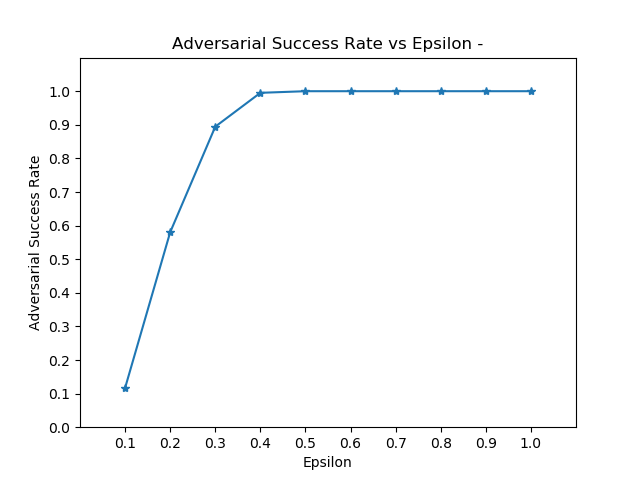

In [23]:
# sample epsilon curve
img = Image.open(os.path.join(model_dir, "attack-fgsm", "epsilon-curve.png"))
display(img)

# note: comparing the epsilon curve with confidence loss trained model, or non adv trained model,
# this model performs poorly despite the adversarial training

In [32]:
# summary epsilon plot for comparison
org_eval_dir=os.path.join(model_dir, "eval")
os.makedirs(os.path.join(model_dir, 'epsilon-curve-comparison'))
misc_adv_success_normal = plot_mis_adv_success(os.path.join('runtime-model-vgg6-50epochs','eval'), os.path.join('runtime-model-vgg6-50epochs', 'attack-fgsm'), epsilon_list, os.path.join(model_dir, 'epsilon-curve-comparison'))
misc_adv_success_robust_confidence = plot_mis_adv_success(os.path.join('runtime-model-vgg6-50epochs-robust', 'eval'), os.path.join('runtime-model-vgg6-50epochs-robust', 'attack-fgsm'), epsilon_list, os.path.join(model_dir, 'epsilon-curve-comparison'))
misc_adv_success_robust_dentropy = plot_mis_adv_success(os.path.join('runtime-model-vgg6-50epochs-robust-dentropy', 'eval'), os.path.join('runtime-model-vgg6-50epochs-robust-dentropy', 'attack-fgsm'), epsilon_list, os.path.join(model_dir, 'epsilon-curve-comparison'))
misc_adv_success_robust_dentropy_out = plot_mis_adv_success(org_eval_dir, os.path.join(model_dir, 'attack-fgsm'), epsilon_list, os.path.join(model_dir, 'epsilon-curve-comparison'))

plot_many_epsilon_curves(epsilon_list, [misc_adv_success_normal, misc_adv_success_robust_confidence, misc_adv_success_robust_dentropy, misc_adv_success_robust_dentropy_out], ['No adv training','Adv trained w. Confidence', 'Adv trained w. Diff_Entropy (in+out adv)', 'Adv trained w. Diff_Entropy (out adv)'], ' confidence attack - MNIST (testset)- Misclassification success', model_dir, 'fgsm-epsilon-summary.png')


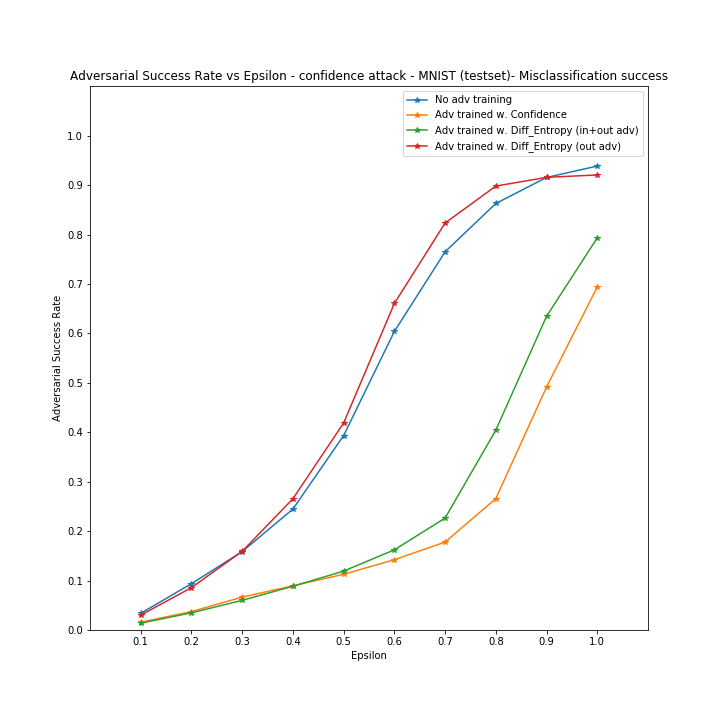

In [33]:
display(Image.open(os.path.join(model_dir, 'fgsm-epsilon-summary.png')))

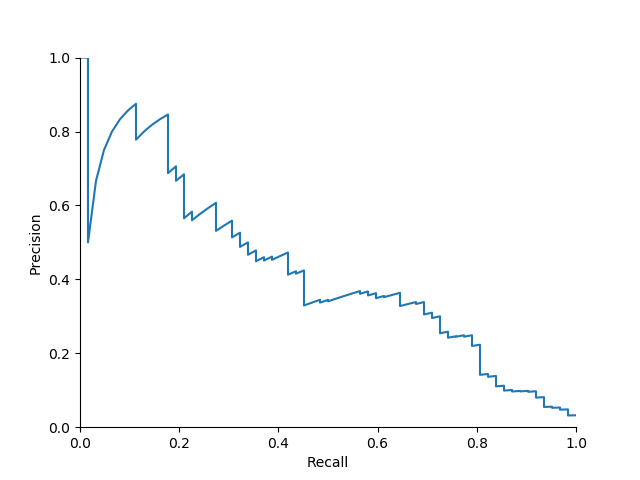

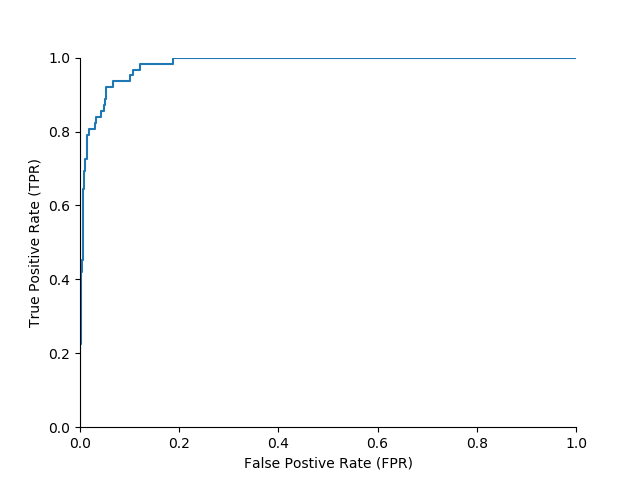

In [24]:
# model before attack
display_pr_roc_curves(model_dir, 'eval', UncertaintyMeasuresEnum.CONFIDENCE)

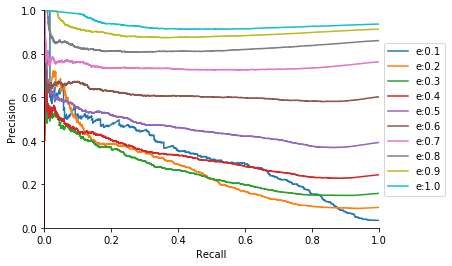

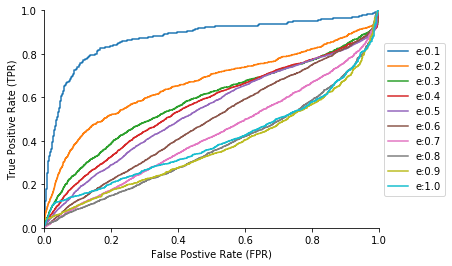

In [35]:
# model under attack (without adv training)
measure = UncertaintyMeasuresEnum.CONFIDENCE
display(Image.open(os.path.join('runtime-model-vgg6-50epochs', 'attack-fgsm', f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join('runtime-model-vgg6-50epochs', 'attack-fgsm', f"{measure._value_}_ROC_summary.png")))

In [25]:
# model under attack (after adv training)
attack_dir=os.path.join(model_dir, "attack-fgsm")
measure = UncertaintyMeasuresEnum.CONFIDENCE
plot_all_roc_curves(epsilon_list, attack_dir, 'eval', measure, attack_dir)
plot_all_pr_curves(epsilon_list, attack_dir, 'eval', measure, attack_dir)

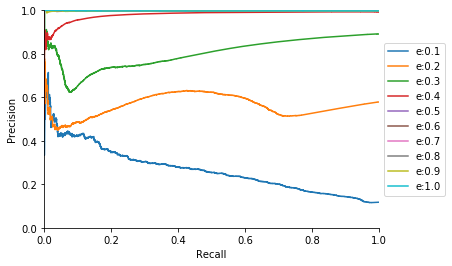

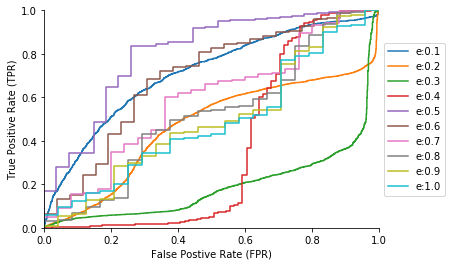

In [26]:
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_ROC_summary.png")))

# Misclassified samples under attack:  9973
# Correct classified samples prior attack:  9938
# Real adversarial samples under attack:  9938


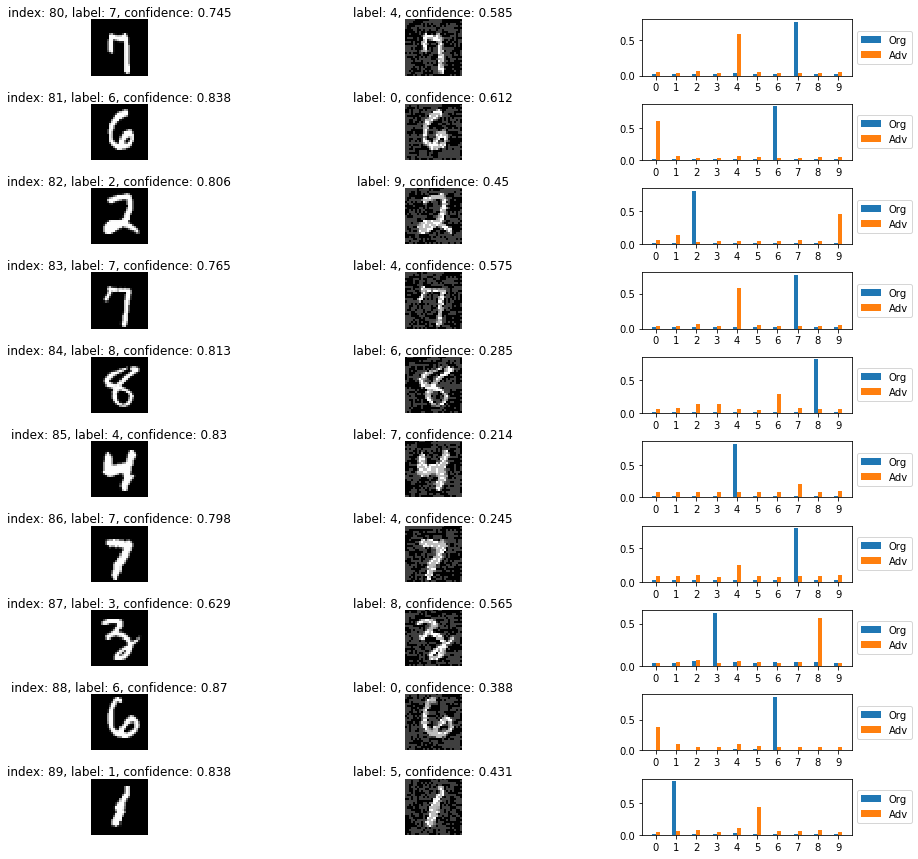

In [27]:
# some adversarial samples
attack_dir=os.path.join(model_dir, "attack-fgsm")
org_eval_dir=os.path.join(model_dir, "eval")
create_vis_plots(org_eval_dir, attack_dir, 0.5, limit=100)

## FGSM attack on confidence (trainset MNIST + SVHN) - ood detect eval

### Eval task on train set (only 5000 images)

In [28]:
out_dir=model_dir+"/ood-eval-train-svhn"
cmd = f"python -m robust_priornet.eval_priornet --gpu -1 --batch_size {batch_size} --task ood_detect --train_dataset --dataset_size_limit 5000 --model_dir {model_dir} --result_dir {out_dir} {data_dir} {in_dataset} {ood_dataset}"
print(cmd)

python -m robust_priornet.eval_priornet --gpu -1 --batch_size 64 --task ood_detect --train_dataset --dataset_size_limit 5000 --model_dir runtime-model-vgg6-50epochs-robust-train-dentropy --result_dir runtime-model-vgg6-50epochs-robust-train-dentropy/ood-eval-train-svhn ./runtime-data MNIST SVHN


In [29]:
os.system(cmd)

0

### Attack

In [30]:
out_dir=model_dir+"/attack-fgsm-train-ood-svhn-conf"

epsilon_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
epsilons = " ".join(map(lambda x: str(x),epsilon_list))

cmd = f"python -m robust_priornet.attack_priornet --gpu -1 --batch_size {batch_size} --attack_type FGSM --attack_criteria confidence --train_dataset --dataset_size_limit 5000 --ood_eval --ood_dataset {ood_dataset} --epsilon {epsilons} --model_dir {model_dir} {data_dir} {in_dataset} {out_dir}"
print(cmd)

python -m robust_priornet.attack_priornet --gpu -1 --batch_size 64 --attack_type FGSM --attack_criteria confidence --train_dataset --dataset_size_limit 5000 --ood_eval --ood_dataset SVHN --epsilon 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 --model_dir runtime-model-vgg6-50epochs-robust-dentropy ./runtime-data MNIST runtime-model-vgg6-50epochs-robust-dentropy/attack-fgsm-train-ood-svhn-conf


In [31]:
os.system(cmd)

0

#### Attack's epsilon curve - confidence

In [32]:
thresholds = [-0.5497,-0.3537,-0.2148,-0.1679,-0.1496,-0.1413,-0.1363,-0.1343,-0.1328,-0.1322]

In [33]:
result_dir = os.path.join(out_dir, 'ood-success-confidence')
os.makedirs(result_dir)
plot_ood_attack_success(epsilon_list, UncertaintyMeasuresEnum.CONFIDENCE, thresholds, out_dir, result_dir)

epsilon: 0.1, threshold: -0.5497
tn: 4904, fp: 96, fn: 1171, tp: 3829, total_id: 5000, total_ood: 5000
epsilon: 0.2, threshold: -0.3537
tn: 4842, fp: 158, fn: 1903, tp: 3097, total_id: 5000, total_ood: 5000
epsilon: 0.3, threshold: -0.2148
tn: 4894, fp: 106, fn: 1891, tp: 3109, total_id: 5000, total_ood: 5000
epsilon: 0.4, threshold: -0.1679
tn: 4888, fp: 112, fn: 1657, tp: 3343, total_id: 5000, total_ood: 5000
epsilon: 0.5, threshold: -0.1496
tn: 4873, fp: 127, fn: 1357, tp: 3643, total_id: 5000, total_ood: 5000
epsilon: 0.6, threshold: -0.1413
tn: 4814, fp: 186, fn: 1045, tp: 3955, total_id: 5000, total_ood: 5000
epsilon: 0.7, threshold: -0.1363
tn: 4616, fp: 384, fn: 702, tp: 4298, total_id: 5000, total_ood: 5000
epsilon: 0.8, threshold: -0.1343
tn: 3855, fp: 1145, fn: 422, tp: 4578, total_id: 5000, total_ood: 5000
epsilon: 0.9, threshold: -0.1328
tn: 2619, fp: 2381, fn: 221, tp: 4779, total_id: 5000, total_ood: 5000
epsilon: 1.0, threshold: -0.1322
tn: 1336, fp: 3664, fn: 112, tp: 

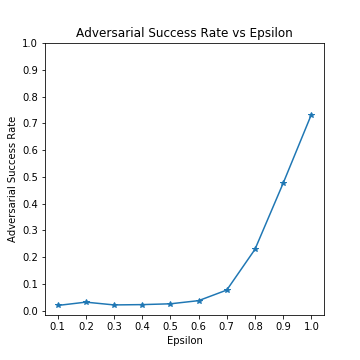

In [34]:
# Plotting in domain adversarial success, in domain sample falsly classified as out domain sample
display(Image.open(os.path.join(out_dir, 'ood-success-confidence', 'epsilon-curve_id.png')))

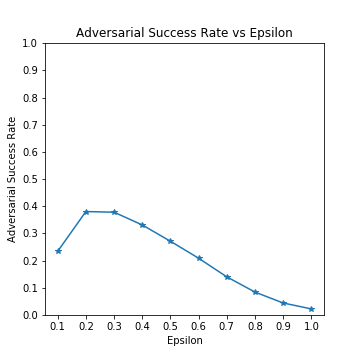

In [35]:
# Plotting out domain adversarial success, out domain sample falsly classified as in domain sample
display(Image.open(os.path.join(out_dir, 'ood-success-confidence', 'epsilon-curve_ood.png')))

#### PR, ROC curves before and after attack - confidence

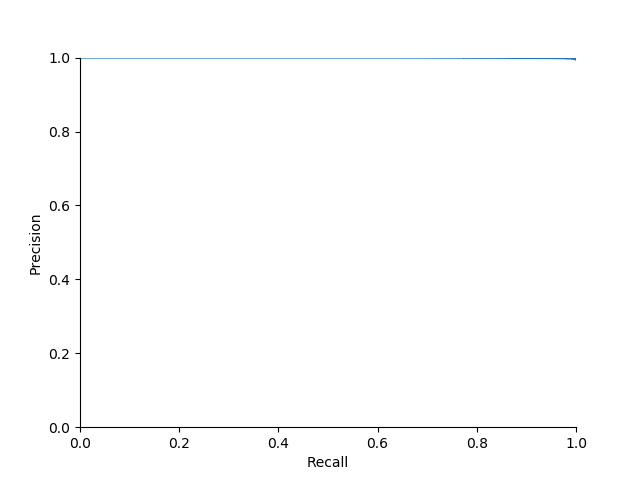

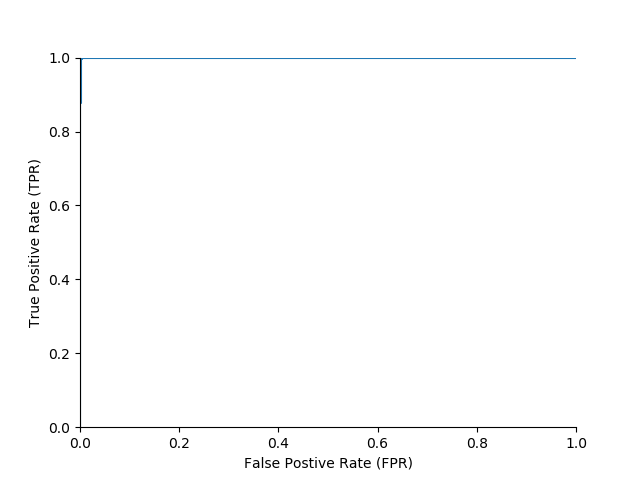

In [36]:
# model before attack
display_pr_roc_curves(model_dir, 'ood-eval-train-svhn', UncertaintyMeasuresEnum.CONFIDENCE)

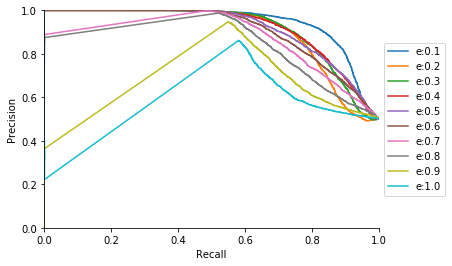

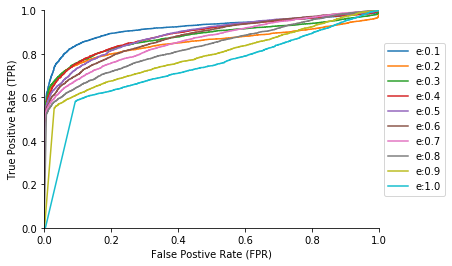

In [37]:
# model under attack - confidence (no adv training)
measure = UncertaintyMeasuresEnum.CONFIDENCE
display(Image.open(os.path.join('runtime-model-vgg6-50epochs', 'attack-fgsm-train-ood-conf-svhn', f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join('runtime-model-vgg6-50epochs', 'attack-fgsm-train-ood-conf-svhn', f"{measure._value_}_ROC_summary.png")))

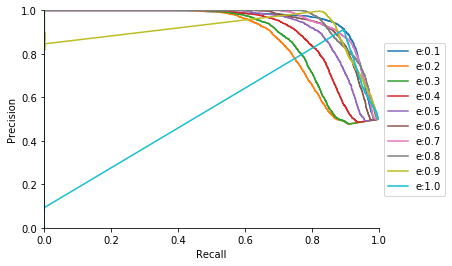

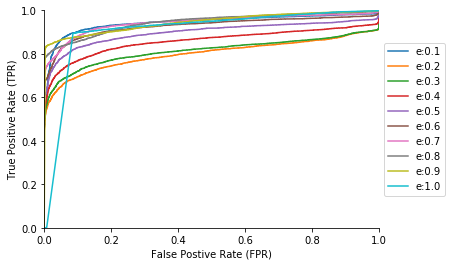

In [38]:
# model under attack - confidence (after adv training)
attack_dir=os.path.join(model_dir, "attack-fgsm-train-ood-svhn-conf")
measure = UncertaintyMeasuresEnum.CONFIDENCE
plot_all_roc_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)
plot_all_pr_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)

display(Image.open(os.path.join(attack_dir, f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_ROC_summary.png")))

#### Some sample adversarial samples

In [39]:
org_eval_dir = os.path.join(model_dir, 'ood-eval-train-svhn')
plot_adv_samples_ood(org_eval_dir, out_dir, 0.5, thresholds[4], UncertaintyMeasuresEnum.CONFIDENCE, plots_dir='vis_confidence', limit=100)

Cross check: fp: 127
Cross check: fn: 1357


1484

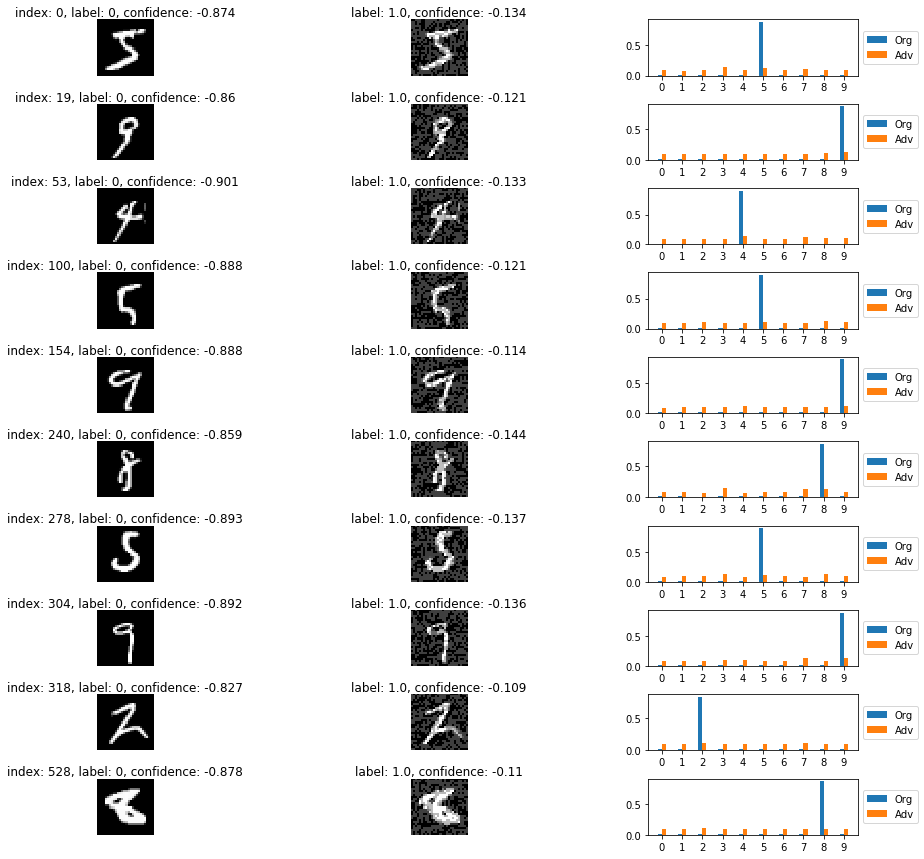

In [40]:
# in domain --> out domain (adversarial success for attacking in domain samples)
display(Image.open(os.path.join(out_dir, f'e0.5-attack', 'vis_confidence', 'in-out', 'result_vis_10.png')))

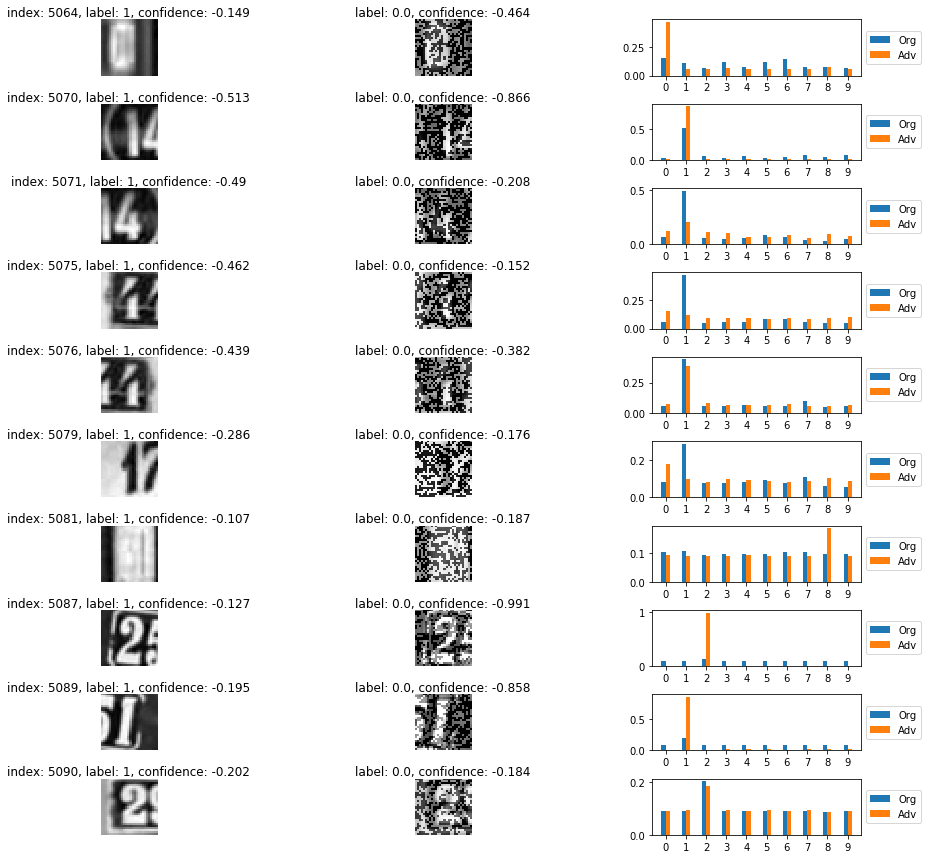

In [41]:
# out domain --> in domain (adversarial success for attacking out domain samples)
display(Image.open(os.path.join(out_dir, f'e0.5-attack', 'vis_confidence', 'out-in', 'result_vis_30.png')))

## FGSM attack on diff entropy (trainset MNIST + SVHN) - ood detect eval

In [30]:
out_dir=model_dir+"/attack-fgsm-train-ood-svhn-dentropy"

epsilon_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
epsilons = " ".join(map(lambda x: str(x),epsilon_list))

cmd = f"python -m robust_priornet.attack_priornet --gpu -1 --batch_size {batch_size} --attack_type FGSM --attack_criteria diff_entropy --train_dataset --dataset_size_limit 5000 --ood_eval --ood_dataset {ood_dataset} --epsilon {epsilons} --model_dir {model_dir} {data_dir} {in_dataset} {out_dir}"
print(cmd)

python -m robust_priornet.attack_priornet --gpu -1 --batch_size 64 --attack_type FGSM --attack_criteria diff_entropy --train_dataset --dataset_size_limit 5000 --ood_eval --ood_dataset SVHN --epsilon 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 --model_dir runtime-model-vgg6-50epochs-robust-train-dentropy ./runtime-data MNIST runtime-model-vgg6-50epochs-robust-train-dentropy/attack-fgsm-train-ood-svhn-dentropy


In [31]:
os.system(cmd)

0

#### Attack's epsilon curve

In [32]:
thresholds = [-18.52049,-14.93081,-13.73132,-13.20055,-13.10584,-13.00481,-12.92809,-12.88405,-12.83937,-12.83091]

In [33]:
result_dir = os.path.join(out_dir, 'ood-success-dentropy')
os.makedirs(result_dir)
id_success, ood_success = plot_ood_attack_success(epsilon_list, UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY, thresholds, out_dir, result_dir)

epsilon: 0.1, threshold: -18.52049
tn: 762, fp: 4238, fn: 912, tp: 4088, total_id: 5000, total_ood: 5000
epsilon: 0.2, threshold: -14.93081
tn: 1369, fp: 3631, fn: 2376, tp: 2624, total_id: 5000, total_ood: 5000
epsilon: 0.3, threshold: -13.73132
tn: 3839, fp: 1161, fn: 3150, tp: 1850, total_id: 5000, total_ood: 5000
epsilon: 0.4, threshold: -13.20055
tn: 4926, fp: 74, fn: 3720, tp: 1280, total_id: 5000, total_ood: 5000
epsilon: 0.5, threshold: -13.10584
tn: 4995, fp: 5, fn: 3867, tp: 1133, total_id: 5000, total_ood: 5000
epsilon: 0.6, threshold: -13.00481
tn: 4999, fp: 1, fn: 3926, tp: 1074, total_id: 5000, total_ood: 5000
epsilon: 0.7, threshold: -12.92809
tn: 5000, fp: 0, fn: 3938, tp: 1062, total_id: 5000, total_ood: 5000
epsilon: 0.8, threshold: -12.88405
tn: 5000, fp: 0, fn: 3941, tp: 1059, total_id: 5000, total_ood: 5000
epsilon: 0.9, threshold: -12.83937
tn: 5000, fp: 0, fn: 3941, tp: 1059, total_id: 5000, total_ood: 5000
epsilon: 1.0, threshold: -12.83091
tn: 5000, fp: 0, fn: 

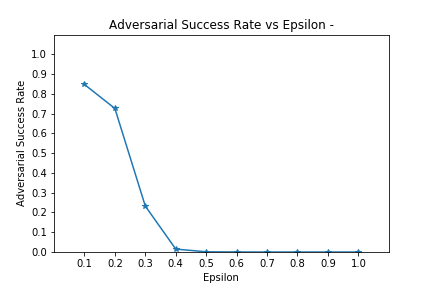

In [34]:
# Plotting in domain adversarial success, in domain sample falsly classified as out domain sample
display(Image.open(os.path.join(out_dir, 'ood-success-dentropy', 'epsilon-curve_id.png')))

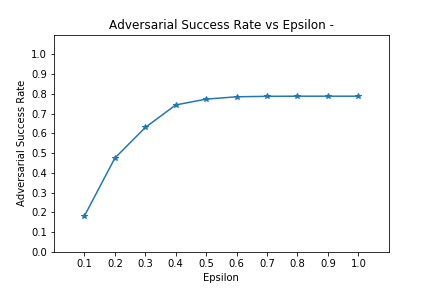

In [35]:
# Plotting out domain adversarial success, out domain sample falsly classified as in domain sample
display(Image.open(os.path.join(out_dir, 'ood-success-dentropy', 'epsilon-curve_ood.png')))

In [36]:
# summary epsilon plot
epsilon_summary_dir = os.path.join(model_dir, 'epsilon-curve-comparison')
os.makedirs(epsilon_summary_dir)
id_adv_success_normal, ood_adv_success_normal = plot_ood_attack_success(epsilon_list, UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY, thresholds, os.path.join('runtime-model-vgg6-50epochs', 'attack-fgsm-train-ood-svhn-dentropy'), epsilon_summary_dir, verbose=False)
id_adv_success_robust_confidence, ood_adv_success_robust_confidence = plot_ood_attack_success(epsilon_list, UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY, thresholds, os.path.join('runtime-model-vgg6-50epochs-robust', 'attack-fgsm-train-ood-svhn-dentropy'), epsilon_summary_dir, verbose=False)
id_adv_success_robust_dentropy, ood_adv_success_robust_dentropy = plot_ood_attack_success(epsilon_list, UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY, thresholds, os.path.join('runtime-model-vgg6-50epochs-robust-dentropy', 'attack-fgsm-train-ood-svhn-dentropy'), epsilon_summary_dir, verbose=False)
id_adv_success_robust_train_dentropy, ood_adv_success_robust_train_dentropy = plot_ood_attack_success(epsilon_list, UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY, thresholds, os.path.join(model_dir, 'attack-fgsm-train-ood-svhn-dentropy'), epsilon_summary_dir, verbose=False)

plot_many_epsilon_curves(epsilon_list, [id_adv_success_normal, id_adv_success_robust_confidence, id_adv_success_robust_dentropy, id_adv_success_robust_train_dentropy], ['No adv training', 'Adv trained w. Confidence', 'Adv trained w. Diff_Entropy (adv gen before training)', 'Adv trained w. Diff_Entropy (adv gen during training)'], ' Diff entropy attack - MNIST+SVHN (trainset) - in->out success', model_dir, 'fgsm-epsilon-summary-in-out.png')
plot_many_epsilon_curves(epsilon_list, [ood_adv_success_normal, ood_adv_success_robust_confidence, ood_adv_success_robust_dentropy, ood_adv_success_robust_train_dentropy], ['No adv training', 'Adv trained w. Confidence', 'Adv trained w. Diff_Entropy (adv gen before training)', 'Adv trained w. Diff_Entropy (adv gen during training)'], ' Diff entropy attack - MNIST+SVHN (trainset) - out->in success', model_dir, 'fgsm-epsilon-summary-out-in.png')


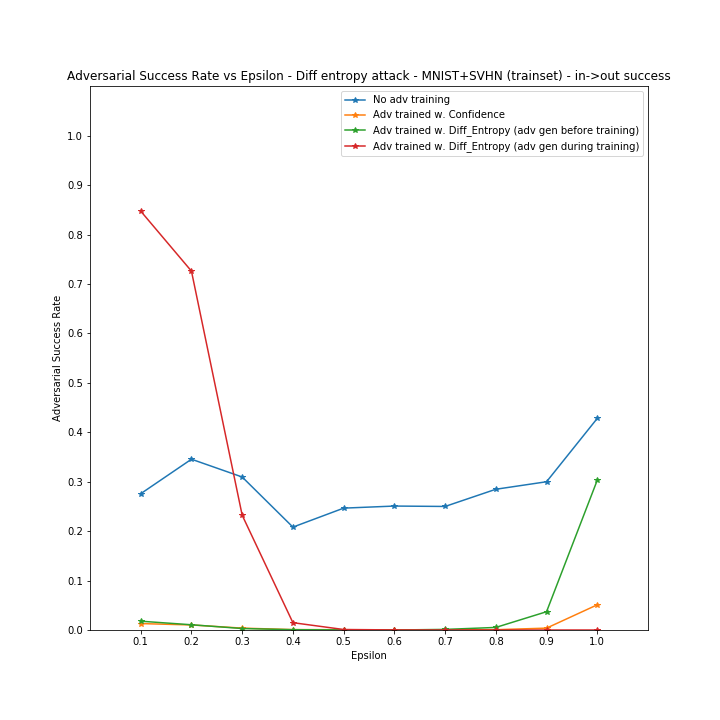

In [37]:
display(Image.open(os.path.join(model_dir, 'fgsm-epsilon-summary-in-out.png')))

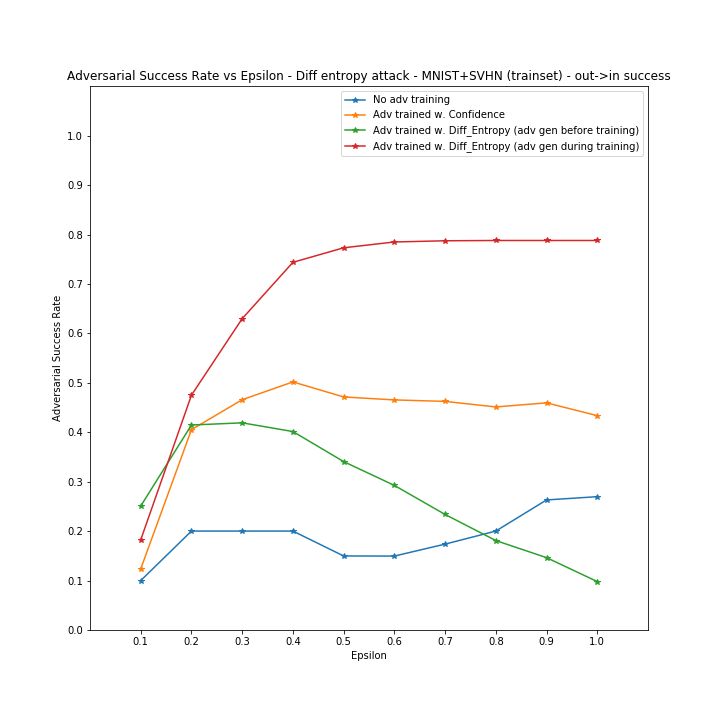

In [38]:
display(Image.open(os.path.join(model_dir, 'fgsm-epsilon-summary-out-in.png')))

#### PR, ROC curves before and after attack

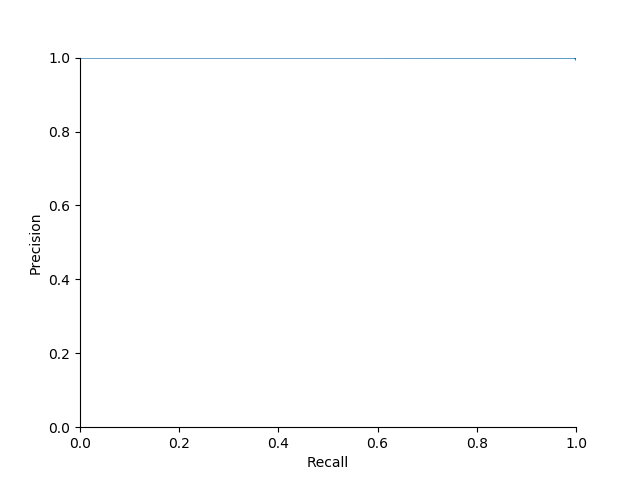

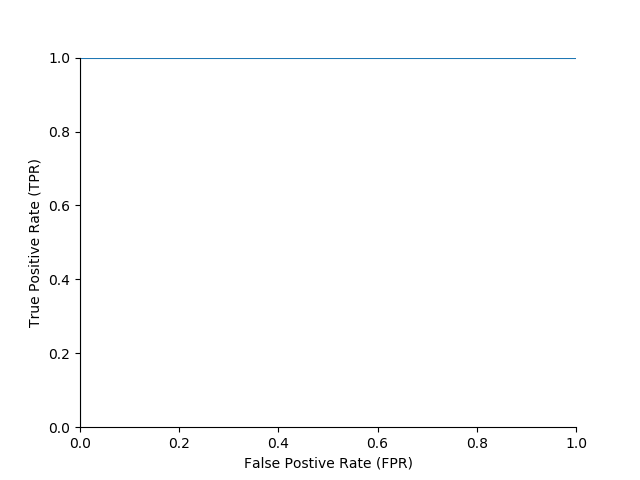

In [39]:
# model before attack
display_pr_roc_curves(model_dir, 'ood-eval-train-svhn', UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY)

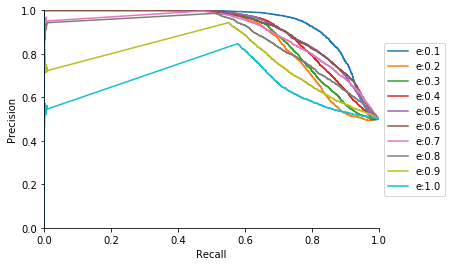

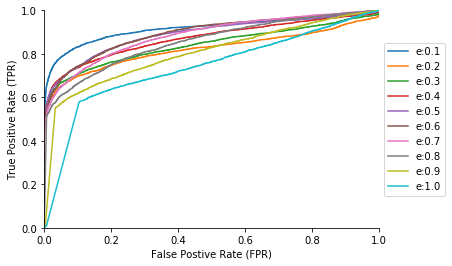

In [49]:
# model under attack - diff entropy (no adv training)
measure = UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY
display(Image.open(os.path.join('runtime-model-vgg6-50epochs', 'attack-fgsm-train-ood-svhn', f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join('runtime-model-vgg6-50epochs', 'attack-fgsm-train-ood-svhn', f"{measure._value_}_ROC_summary.png")))

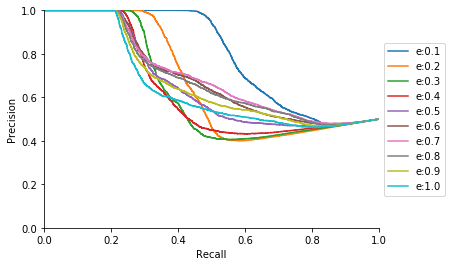

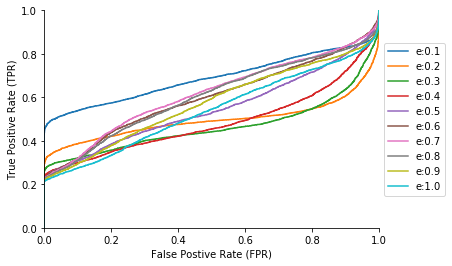

In [40]:
# model under attack - diff entropy (after adv training)
attack_dir=os.path.join(model_dir, "attack-fgsm-train-ood-svhn-dentropy")
measure = UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY
plot_all_roc_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)
plot_all_pr_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)

display(Image.open(os.path.join(attack_dir, f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_ROC_summary.png")))

## FGSM attack on diff entropy (trainset MNIST + OMNIGLOT) - ood detect eval

In [26]:
ood_dataset = "OMNIGLOT"
out_dir=model_dir+"/attack-fgsm-train-ood-dentropy"

epsilon_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
epsilons = " ".join(map(lambda x: str(x),epsilon_list))

cmd = f"python -m robust_priornet.attack_priornet --gpu -1 --batch_size {batch_size} --attack_type FGSM --attack_criteria diff_entropy --train_dataset --dataset_size_limit 5000 --ood_eval --ood_dataset {ood_dataset} --epsilon {epsilons} --model_dir {model_dir} {data_dir} {in_dataset} {out_dir}"
print(cmd)

python -m robust_priornet.attack_priornet --gpu -1 --batch_size 64 --attack_type FGSM --attack_criteria diff_entropy --train_dataset --dataset_size_limit 5000 --ood_eval --ood_dataset OMNIGLOT --epsilon 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 --model_dir runtime-model-vgg6-50epochs-robust-train-dentropy ./runtime-data MNIST runtime-model-vgg6-50epochs-robust-train-dentropy/attack-fgsm-train-ood-dentropy


In [27]:
os.system(cmd)

0

#### Attack's epsilon curve

In [28]:
thresholds = [-18.52049,-14.93081,-13.73132,-13.20055,-13.10584,-13.00481,-12.92809,-12.88405,-12.83937,-12.83091]

In [29]:
result_dir = os.path.join(out_dir, 'ood-success-dentropy')
os.makedirs(result_dir)
id_success, ood_success = plot_ood_attack_success(epsilon_list, UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY, thresholds, out_dir, result_dir)

epsilon: 0.1, threshold: -18.52049
tn: 0, fp: 5000, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 0.2, threshold: -14.93081
tn: 1618, fp: 3382, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 0.3, threshold: -13.73132
tn: 3756, fp: 1244, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 0.4, threshold: -13.20055
tn: 4714, fp: 286, fn: 2, tp: 4998, total_id: 5000, total_ood: 5000
epsilon: 0.5, threshold: -13.10584
tn: 4870, fp: 130, fn: 3, tp: 4997, total_id: 5000, total_ood: 5000
epsilon: 0.6, threshold: -13.00481
tn: 4955, fp: 45, fn: 4, tp: 4996, total_id: 5000, total_ood: 5000
epsilon: 0.7, threshold: -12.92809
tn: 4983, fp: 17, fn: 6, tp: 4994, total_id: 5000, total_ood: 5000
epsilon: 0.8, threshold: -12.88405
tn: 4993, fp: 7, fn: 6, tp: 4994, total_id: 5000, total_ood: 5000
epsilon: 0.9, threshold: -12.83937
tn: 5000, fp: 0, fn: 8, tp: 4992, total_id: 5000, total_ood: 5000
epsilon: 1.0, threshold: -12.83091
tn: 5000, fp: 0, fn: 8, tp: 4992, total_id: 

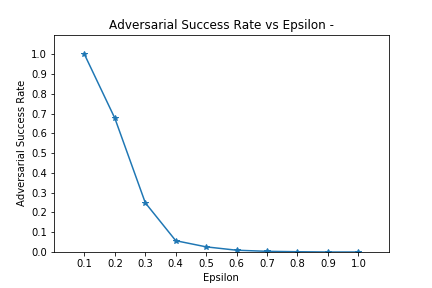

In [30]:
# Plotting in domain adversarial success, in domain sample falsly classified as out domain sample
display(Image.open(os.path.join(out_dir, 'ood-success-dentropy', 'epsilon-curve_id.png')))

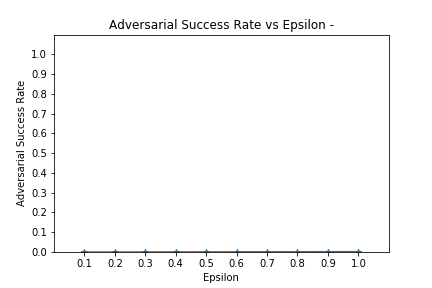

In [31]:
# Plotting out domain adversarial success, out domain sample falsly classified as in domain sample
display(Image.open(os.path.join(out_dir, 'ood-success-dentropy', 'epsilon-curve_ood.png')))

In [37]:
# same measure before attack (using threshold value based on no attack eval, tpr=1.0, fpr=0.001)
id_dist_un = np.loadtxt(os.path.join(model_dir, 'ood-eval-train-svhn', 'id_differential_entropy.txt'))
ood_dist_un = np.loadtxt(os.path.join(model_dir, 'ood-eval-train-svhn', 'ood_differential_entropy.txt'))
y_preds = np.concatenate((id_dist_un, ood_dist_un), axis=0)
y_true = np.concatenate((np.zeros_like(id_dist_un), np.ones_like(ood_dist_un)), axis=0)
tn, fp, fn, tp = ClassifierPredictionEvaluator.compute_confusion_matrix_entries(y_preds, y_true, -19.03791)
print(f"tn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}, total: {len(y_true)}")

tn: 3255, fp: 1745, fn: 0, tp: 5000, total: 10000


In [61]:
# summary epsilon plot
epsilon_summary_dir = os.path.join(model_dir, 'epsilon-curve-comparison')
os.makedirs(epsilon_summary_dir)
id_adv_success_normal, ood_adv_success_normal = plot_ood_attack_success(epsilon_list, UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY, thresholds, os.path.join('runtime-model-vgg6-50epochs', 'attack-fgsm-train-ood-dentropy'), epsilon_summary_dir, verbose=False)
id_adv_success_robust_confidence, ood_adv_success_robust_confidence = plot_ood_attack_success(epsilon_list, UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY, thresholds, os.path.join('runtime-model-vgg6-50epochs-robust', 'attack-fgsm-train-ood-dentropy'), epsilon_summary_dir, verbose=False)
id_adv_success_robust_dentropy, ood_adv_success_robust_dentropy = plot_ood_attack_success(epsilon_list, UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY, thresholds, os.path.join('runtime-model-vgg6-50epochs-robust-dentropy', 'attack-fgsm-train-ood-dentropy'), epsilon_summary_dir, verbose=False)
id_adv_success_robust_dentropy_out, ood_adv_success_robust_dentropy_out = plot_ood_attack_success(epsilon_list, UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY, thresholds, os.path.join(model_dir, 'attack-fgsm-train-ood-dentropy'), epsilon_summary_dir, verbose=False)

plot_many_epsilon_curves(epsilon_list, [id_adv_success_normal, id_adv_success_robust_confidence, id_adv_success_robust_dentropy, id_adv_success_robust_dentropy_out], ['No adv training', 'Adv trained w. Confidence', 'Adv trained w. Diff_Entropy (in+out adv)', 'Adv trained w. Diff_Entropy (out adv)'], ' Diff entropy attack - MNIST + OMNIGLOT (trainset) - in->out success', model_dir, 'fgsm-epsilon-summary-in-out-omniglot.png')
plot_many_epsilon_curves(epsilon_list, [ood_adv_success_normal, ood_adv_success_robust_confidence, ood_adv_success_robust_dentropy, ood_adv_success_robust_dentropy_out], ['No adv training', 'Adv trained w. Confidence', 'Adv trained w. Diff_Entropy (in+out adv)', 'Adv trained w. Diff_Entropy (out adv)'], ' Diff entropy attack - MNIST + OMNIGLOT (trainset) - out->in success', model_dir, 'fgsm-epsilon-summary-out-in-omniglot.png')


/nfs/homedirs/giri/masterthesis/robust_priornet/utils/visualizer.py:245: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, plt_axis = plt.subplots(nrows=1, ncols=1)
/nfs/homedirs/giri/masterthesis/robust_priornet/utils/visualizer.py:245: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, plt_axis = plt.subplots(nrows=1, ncols=1)
/nfs/homedirs/giri/masterthesis/robust_priornet/utils/visualizer.py:245: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until e

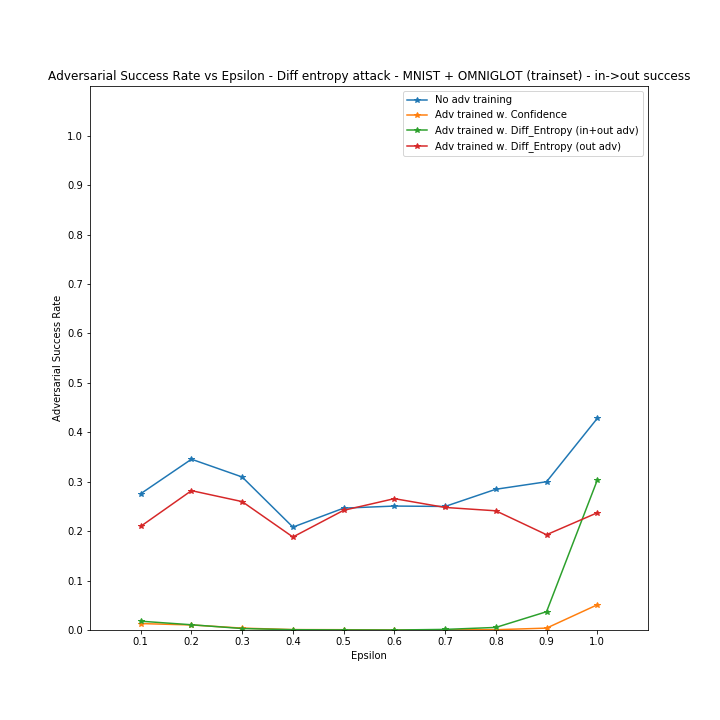

In [62]:
display(Image.open(os.path.join(model_dir, 'fgsm-epsilon-summary-in-out-omniglot.png')))

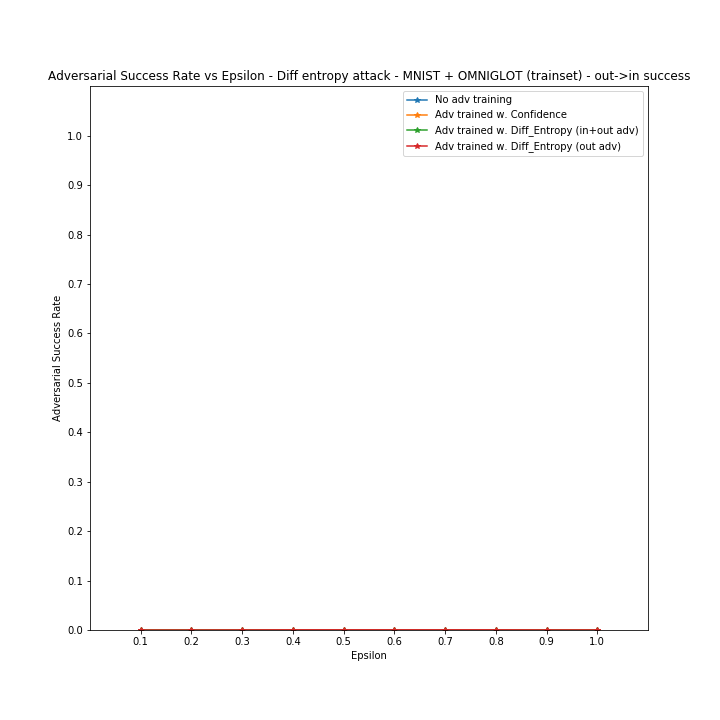

In [63]:
display(Image.open(os.path.join(model_dir, 'fgsm-epsilon-summary-out-in-omniglot.png')))